In [4]:
import numpy as np
import collections
import matplotlib.pyplot as plt

from scipy.special import logsumexp

import geometry
import itertools
from collections import defaultdict
import collections

from functools import reduce

from multiprocess import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import feedexp3
import geometry_v2
import cpb
# import cpb_uniform
import cpb_gaussian
import feedexp3_v2
import bpm
import random_algo
import feedexp3_v3
import plotly.graph_objects as go
import TSPM
# import eTSPM
# import ucbtspm
# import ucbTSPM_v2
# import eTSPM_info
import PM_DMED
import synthetic_data
import cpb_side

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []
    context_generators = []

    for jobid in range(n_folds):
        
        p = np.random.uniform(0, 0.2) if type == 'easy' else np.random.uniform(0.4,0.5)
        distributions.append( [p, 1-p] )

        d = 2 #np.random.randint(1,10)
        margin = 0.3 #np.random.uniform(0.2,0.5)
        contexts = synthetic_data.LinearContexts(d, margin)
        contexts.make_task()
        context_generators.append( contexts )


    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions , context_generators ,range(n_folds)) ) ) 


class Evaluation:

    def __init__(self, horizon,type ):
        self.type = type
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, context_generator, jobid = job

        np.random.seed(jobid)
        
        # outcome_distribution =  {'spam':0.05,'ham':0.95}

        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        # p = get_easy() if game.mode == 'easy' else get_harsch() 
        # outcome_distribution =  {'a':p[0],'b':p[1],'c':p[2],'d':p[3],'e':p[4]}

        game.set_outcome_distribution( outcome_distribution )
        #print('optimal action', game.i_star)

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)
        # contexts = [ context_generator.get_context(outcome) for outcome in outcomes ]
        context_generator.generate_unique_context()
        contexts = [ context_generator.get_context(outcome) for outcome in outcomes ]
        #print('theta', context_generator.w )

        for t in range(self.horizon):

            # Environment chooses one outcome and one context associated to this outcome
            outcome = outcomes[t]
            context = contexts[t]

            # policy chooses one action
            action = alg.get_action(t, context)

            #print('t', t, 'action', action, 'outcome', outcome, )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, context, t)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:

                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter
        
        
        return regret


In [45]:
n_cores = 1
n_folds = 1
horizon = 1000
# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

game =  games.apple_tasting( False ) 

# print('optimal action', game.i_star)
alg = cpb_side.CPB_side(  game, horizon,)

task = Evaluation(horizon, 'easy')

outcome_distribution = [0.4,0.6]
d = 2 #np.random.randint(1,10)
margin = 0.2 #np.random.uniform(0,0.5)
context_generator = synthetic_data.LinearContexts(d, margin)
context_generator.make_task()

job = (outcome_distribution, context_generator, 1 )

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


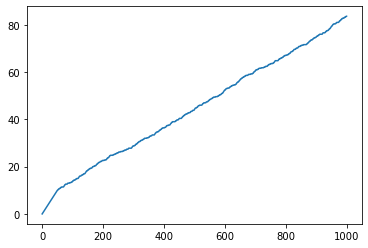

In [46]:
plt.plot(result)

In [3]:

import cpb_gaussian_v2
#import ucbTSPM_v2
n_cores = 8
n_folds = 100
horizon = 500
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.apple_tasting(False)


#feedexp3.FeedExp3(  game, horizon, ),
#feedexp3_v3.FeedExp3(  game, horizon, ),
#eTSPM.eTSPM_alg(  game, horizon, 1),
#TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

#TSPM.TSPM_alg(  game, horizon,), 
#ucbTSPM_v2.TSPM_alg(game, horizon)  

algos = [ random_algo.Random(  game, horizon, ),      
          cpb.CPB(  game, horizon, 1.01), 
          cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10),
          TSPM.TSPM_alg(  game, horizon, 1),  
          PM_DMED.PM_DMED(  game, horizon,)  ] 

        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, True), 
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, False), ]
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01),
        #TSPM.TSPM_alg(game, horizon, 1 ) ]
        #TSPM.TSPM_alg(game, horizon, 0 )   #eTSPM.eTSPM_alg(game, horizon, 1), cpb_uniform.CPB_uniform(  game, horizon, 1.01), 

colors = [  [0,0,0], [250,0,0], [250,0,250], [0,250,0], [0,0,250],    ] #[0,150,0], [0,250,0], [0,150,0], [0,0,250], [0,0,0],  [0,255,0], [0 , 150, 0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], [255,51,255], [255,20,200]  ] #
labels = [  'random',  'CPB',  'RandCPB', 'TSPM', 'PM-DMED'  ]  # 'random', 'TSPM' , 'TSPM (R=0)', 'RandCBP (uncoupled)','CPB uniform', ,'TSPM' , 'ucbTSPM (Auer)' 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'CPB',  'eTSPM (Auer)',


fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'hard')
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 100] )

fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )
#fig.write_image("./hard_AT.pdf")

fig.show()

n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000


In [5]:
#import ucbTSPM_v2
import cpb_gaussian_v2

n_cores = 8
n_folds = 25
horizon = 1000
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.apple_tasting(False)

algos = [ random_algo.Random(  game, horizon, ),      
          cpb_side.CPB_side(  game, horizon,)  ] 

        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, True), 
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, False), ]
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01),
        #TSPM.TSPM_alg(game, horizon, 1 ) ]
        #TSPM.TSPM_alg(game, horizon, 0 )   #eTSPM.eTSPM_alg(game, horizon, 1), cpb_uniform.CPB_uniform(  game, horizon, 1.01), 

colors = [  [0,0,0], [250,0,0],    ] #[0,150,0], [0,250,0], [0,150,0], [0,0,250], [0,0,0],  [0,255,0], [0 , 150, 0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], [255,51,255], [255,20,200]  ] #
labels = [  'random',  'CPB-side',  ]  # 'random', 'TSPM' , 'TSPM (R=0)', 'RandCBP (uncoupled)','CPB uniform', ,'TSPM' , 'ucbTSPM (Auer)' 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'CPB',  'eTSPM (Auer)',

fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=True )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 20] )
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )
#fig.write_image("./easy_AT.pdf")

fig.show()

nbCores: 8 nbFolds: 25 Horizon: 1000
nbCores: 8 nbFolds: 25 Horizon: 1000
